In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import qkeras
from qkeras import *
from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)
import hls4ml
from QDenseBatchnorm import QDenseBatchnorm
import hls4ml.utils
import hls4ml.converters

2026-02-17 12:17:30.009033: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-17 12:17:30.073588: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-17 12:17:30.073632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-17 12:17:30.075142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-17 12:17:30.088438: I tensorflow/core/platform/cpu_feature_guar

In [2]:
teacher = keras.models.load_model('../saved_models/teacher_864X64')
student_test = qkeras.utils.load_qmodel('../saved_models/student_864X64')

In [3]:
student_test.summary()

Model: "v1_12X12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_ (InputLayer)        [(None, 55296)]           0         
                                                                 
 dense1 (QDenseBatchnorm)    (None, 16)                884817    
                                                                 
 relu1 (QActivation)         (None, 16)                0         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense2 (QDense)             (None, 1)                 16        
                                                                 
 outputs (QActivation)       (None, 1)                 0         
                                                                 
Total params: 884833 (3.38 MB)
Trainable params: 884800 (3

In [4]:
def loss(y_true, y_pred, choice):
    if choice == 'mse':
        loss = np.mean((y_true - y_pred)**2, axis = (1,2,3))
        return loss

ntimeticks = 6400
nwire = 3456
f_downsample = 10
h_split = 10
v_split = 4
nbatch = 32

strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

adccutoff = 10.*f_downsample/10.
adcsaturation = 100.*f_downsample/10.

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices: 1


In [5]:
X = np.load("../data/bnb_WithWire_00_batch_00_864X64.npy")
X_flat = X.reshape((X.shape[0],-1))

X_predict_teacher = teacher.predict(X)
X_loss_teacher = loss(X, X_predict_teacher, 'mse')
Y = student_test.predict(X_flat).reshape(len(X_loss_teacher))

np.savetxt("../data/teacher_864X64_prediction.dat", X_loss_teacher, fmt="%.8f", delimiter=" ")
np.savetxt("../data/student_864X64_qkeras_prediction.dat", Y, fmt="%.8f", delimiter=" ")

80/80 [==============================] - 0s 4ms/step


In [6]:
X = np.load("../data/bnb_WithWire_00_batch_00_864X64.npy")
print(X.shape)
X_flat = X.reshape((X.shape[0],-1))
print(X_flat.shape)
X_loss_teacher = np.loadtxt("../data/teacher_864X64_prediction.dat")
Y = np.loadtxt("../data/student_864X64_qkeras_prediction.dat")

(2560, 864, 64, 1)
(2560, 55296)


Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 55296]], output shape: [None, 55296]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 55296]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 55296]], output shape: [None, 55296]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 55296]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input s

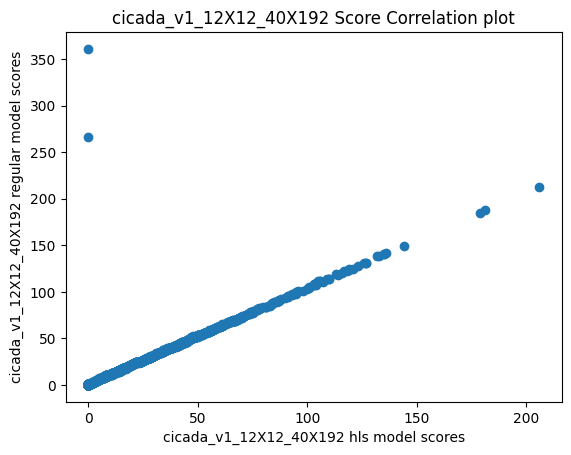

In [18]:
config = hls4ml.utils.config_from_keras_model(
    student_test,
    backend="Vitis",
    default_precision="fixed<18,9>",
    granularity="name"
)

# Global knobs
config["Model"]["Strategy"] = "Resource"
config["Model"]["ReuseFactor"] = 256   # start here
config["Model"]["PipelineStyle"] = "pipeline"  # keep if it works; hls4ml may flip to dataflow

# Dense1 is 288x16 = 4608 MACs: fold it hard
config["LayerName"]["dense1"]["Strategy"] = "Resource"
config["LayerName"]["dense1"]["ReuseFactor"] = 110592   # valid set per your log
# If available in your version:
# config["LayerName"]["dense1"]["MultiplierLimit"] = 64 # try 32/64/128

# Dense2 is tiny; keep moderate reuse
config["LayerName"]["dense2"]["Strategy"] = "Resource"
config["LayerName"]["dense2"]["ReuseFactor"] = 16

hls_model = hls4ml.converters.convert_from_keras_model(
    student_test,
    hls_config=config,
    io_type="io_stream",
    backend="Vitis",
    output_dir="../saved_models/864X64_folded"
)

hls_model.compile()
fake_hls4ml_pred, hls4ml_trace = hls_model.trace(X)
y_predict_hls4ml_q = hls_model.predict(X_flat).reshape(len(X_loss_teacher))

import matplotlib.pyplot as plt
plt.scatter(y_predict_hls4ml_q, Y)
plt.xlabel('cicada_v1_12X12_40X192 hls model scores')
plt.ylabel('cicada_v1_12X12_40X192 regular model scores')
plt.title('cicada_v1_12X12_40X192 Score Correlation plot')
plt.show()

In [19]:
hls_model.build(csim=False)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.1 (64-bit)
  **** SW Build 3854077 on May  4 2023
  **** IP Build 3864474 on Sun May  7 20:36:21 MDT 2023
  **** SharedData Build 3865790 on Sun May 07 13:33:03 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /scratch/am_vitis/Vitis_HLS/2023.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/scratch/am_vitis/Vitis_HLS/2023.1/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'RAD' on host 'cleopatra.nevis.columbia.edu' (Linux_x86_64 version 3.10.0-1160.31.1.el7.x86_64) on Tue Feb 17 15:24:51 EST 2026
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/mnt/storage1/RAD/RAD_FPGA/saved_models/864X64_folded'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/mnt/stora

{}